<a href="https://colab.research.google.com/github/heejjj/Sleeping_Project/blob/main/weekday_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## 해당 경로에 있는 .csv 파일명 리스트 가져오기

import os

path = '/content/drive/MyDrive/KDT_project/Hackathon/data_edit'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')] ## 파일명 끝이 .csv인 경우

In [ ]:
file_list_py

['April_28.csv',
 'May_1.csv',
 'April_13.csv',
 'April_26.csv',
 'April_30.csv',
 'April_21.csv',
 'April_11.csv',
 'April_29.csv',
 'April_19.csv',
 'April_25.csv',
 'April_17.csv',
 'April_27.csv',
 'April_12.csv',
 'May_2.csv',
 'May_3.csv',
 'April_14.csv',
 'April_24.csv',
 'April_15.csv',
 'April_9.csv',
 'April_23.csv',
 'April_16.csv',
 'March_29.csv',
 'April_5.csv',
 'April_10.csv',
 'April_18.csv',
 'April_4.csv',
 'April_3.csv',
 'April_8.csv',
 'April_7.csv',
 'March_23.csv',
 'April_1.csv',
 'Feb_26.csv',
 'March_25.csv',
 'Feb_27.csv',
 'April_20.csv',
 'March_31.csv',
 'March_20.csv',
 'March_28.csv',
 'Feb_28.csv',
 'March_27.csv',
 'March_18.csv',
 'March_13.csv',
 'March_19.csv',
 'March_24.csv',
 'March_30.csv',
 'March_11.csv',
 'March_15.csv',
 'March_17.csv',
 'March_22.csv',
 'March_12.csv',
 'April_6.csv',
 'March_2.csv',
 'April_2.csv',
 'March_4.csv',
 'March_7.csv',
 'March_3.csv',
 'March_8.csv',
 'March_10.csv',
 'March_16.csv',
 'March_6.csv',
 'March_14

In [ ]:
cd /content/drive/MyDrive/KDT_project/Hackathon/data_edit

/content/drive/.shortcut-targets-by-id/13O52Rq0xFs4zNhGbjb6yiZfychPQKgr5/Hackathon/data_edit


In [ ]:
# 폴더에 있는 파일 가져와서 데이터프레임으로 합치기
data_concat = pd.DataFrame()

for files in file_list_py:
    df= pd.read_csv(files)
    data_concat = pd.concat([data_concat, df])

In [ ]:
data_concat = data_concat.drop('Unnamed: 0', axis=1)
data_concat.head()

,Start,End,Duration (hr),Value,Source,year_month_day,weekday
0,2023-04-28 01:04:20,2023-04-28 01:06:20,0.033,2,Sujeong의 Apple Watch,2023-04-28,4
1,2023-04-28 01:06:20,2023-04-28 01:17:50,0.192,4,Sujeong의 Apple Watch,2023-04-28,4
2,2023-04-28 01:17:50,2023-04-28 01:36:20,0.308,2,Sujeong의 Apple Watch,2023-04-28,4
3,2023-04-28 01:36:20,2023-04-28 02:19:20,0.717,1,Sujeong의 Apple Watch,2023-04-28,4
4,2023-04-28 02:19:20,2023-04-28 02:36:20,0.283,2,Sujeong의 Apple Watch,2023-04-28,4


In [ ]:
Mon = data_concat[data_concat["weekday"]==0]
Tue = data_concat[data_concat["weekday"]==1]
Wed = data_concat[data_concat["weekday"]==2]
Thur = data_concat[data_concat["weekday"]==3]
Fri = data_concat[data_concat["weekday"]==4]
Sat = data_concat[data_concat["weekday"]==5]
Sun = data_concat[data_concat["weekday"]==6]

In [ ]:
# weekday - 주중 / weekend - 주말
weekday = pd.concat([Mon, Tue, Wed, Thur, Fri])
weekend = pd.concat([Sat, Sun])

In [ ]:
# 날짜 순서대로 정렬
weekday = weekday.sort_values("Start")
weekend = weekend.sort_values("Start")

# 모델에 필요한 데이터 열만 선택
weekday = weekday.loc[:,["Start","Value"]]
weekend = weekend.loc[:,["Start","Value"]]

## weekday

In [ ]:
weekday['Start'] = pd.to_datetime(weekday['Start'], format='%Y-%m-%d %H:%M:%S', errors='raise')
weekday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318 entries, 0 to 20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Start   1318 non-null   datetime64[ns]
 1   Value   1318 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 30.9 KB


In [ ]:
# LSTM 모델에 input 데이터 형태를 맞춰줌
weekday = weekday.set_index(keys = 'Start')
weekday

,Value
Start,
2023-02-26 23:36:12,2
2023-02-26 23:57:42,1
2023-02-27 00:31:12,2
2023-02-27 00:32:12,3
2023-02-27 00:39:12,4
...,...
2023-05-03 06:16:05,2
2023-05-03 06:44:05,3
2023-05-03 07:09:05,2


In [ ]:
# one-step pred
# 크기가 N인 시계열 데이터를 N - seq_length 개의 지도학습용 데이터로 변환
# 지도학습용 데이터 구축하기

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(weekday, seq_length)

In [ ]:
X.shape, y.shape

((1288, 30, 1), (1288, 1))

In [ ]:
# 학습 : 검증 : 시험 =  8:1:1 
train_size = int(X.shape[0] * 0.8)
test_size = int(X.shape[0] * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+test_size], y[train_size:train_size+test_size]
X_test, y_test = X[train_size+test_size:], y[train_size+test_size:]

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1030, 30, 1) (128, 30, 1) (130, 30, 1)
(1030, 1) (128, 1) (130, 1)


In [ ]:
# PyTorch 모델에 입력되기 위해 np.array 데이터 타입를 torch.Tensor 타입으로 변환
import torch

def make_Tensor(array):
  return torch.from_numpy(array).float()

In [ ]:
#@title
# PyTorch 모델에 입력되기 위해 np.array 데이터 타입를 torch.Tensor 타입으로 변환
import torch

def make_Tensor(my_array):
  array = np.array(my_array.tolist())
  return torch.Tensor(array)

In [ ]:
#@title
# PyTorch 모델에 입력되기 위해 np.array 데이터 타입를 torch.Tensor 타입으로 변환
import torch

def make_Tensor(my_array):
  py_list = my_array.tolist()
  return torch.FloatTensor(py_list)

In [ ]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

# LSTM 모델 생성

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# LSTM 모델 생성
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [ ]:
# 학습
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [ ]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 1.1174395782854951 val loss: 0.8507872819900513
Epoch 10 train loss: 0.5660674893740312 val loss: 0.6801810264587402
Epoch 20 train loss: 0.5535958661616427 val loss: 0.6945362091064453
Epoch 30 train loss: 0.5493000458745123 val loss: 0.6991810202598572
Epoch 40 train loss: 0.5467428795342306 val loss: 0.7037038803100586
Epoch 50 train loss: 0.5441372087858256 val loss: 0.705985963344574
Epoch 60 train loss: 0.5424109905668832 val loss: 0.7095479965209961
Epoch 70 train loss: 0.5407034471197035 val loss: 0.7109981775283813
Epoch 80 train loss: 0.5387306584895236 val loss: 0.7150422930717468
Epoch 90 train loss: 0.5360312035940226 val loss: 0.7194520235061646


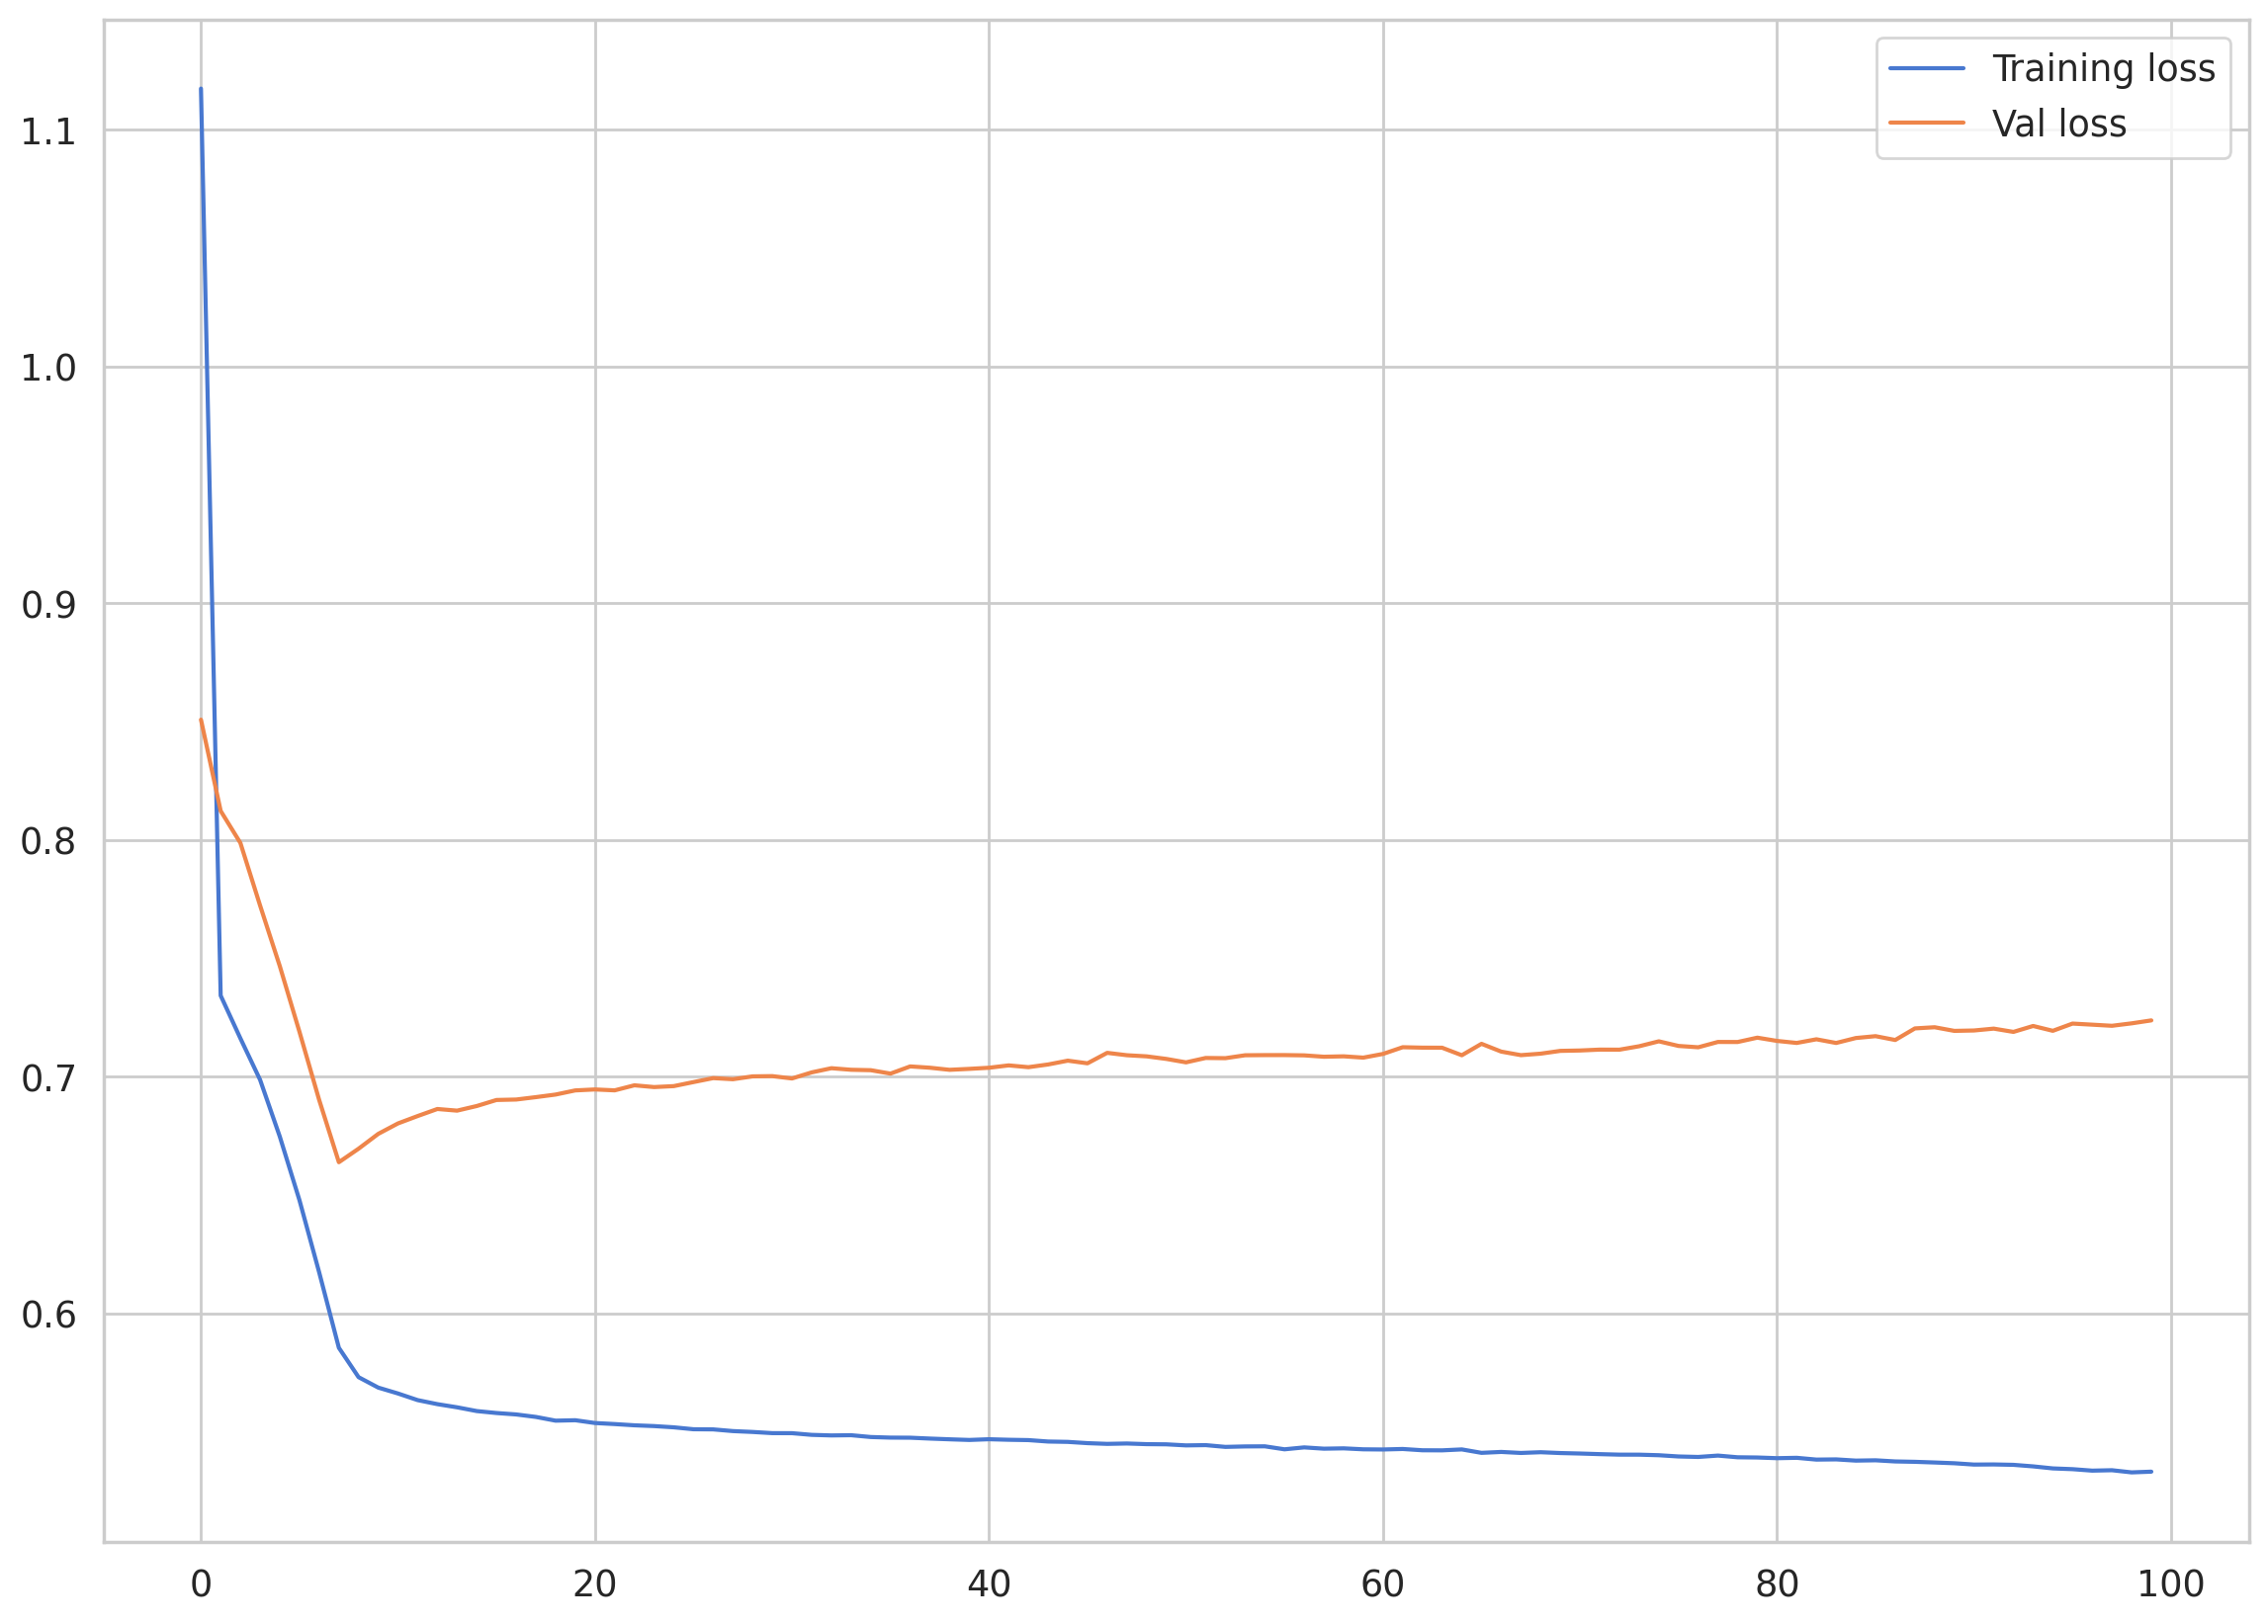

In [ ]:
# int
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

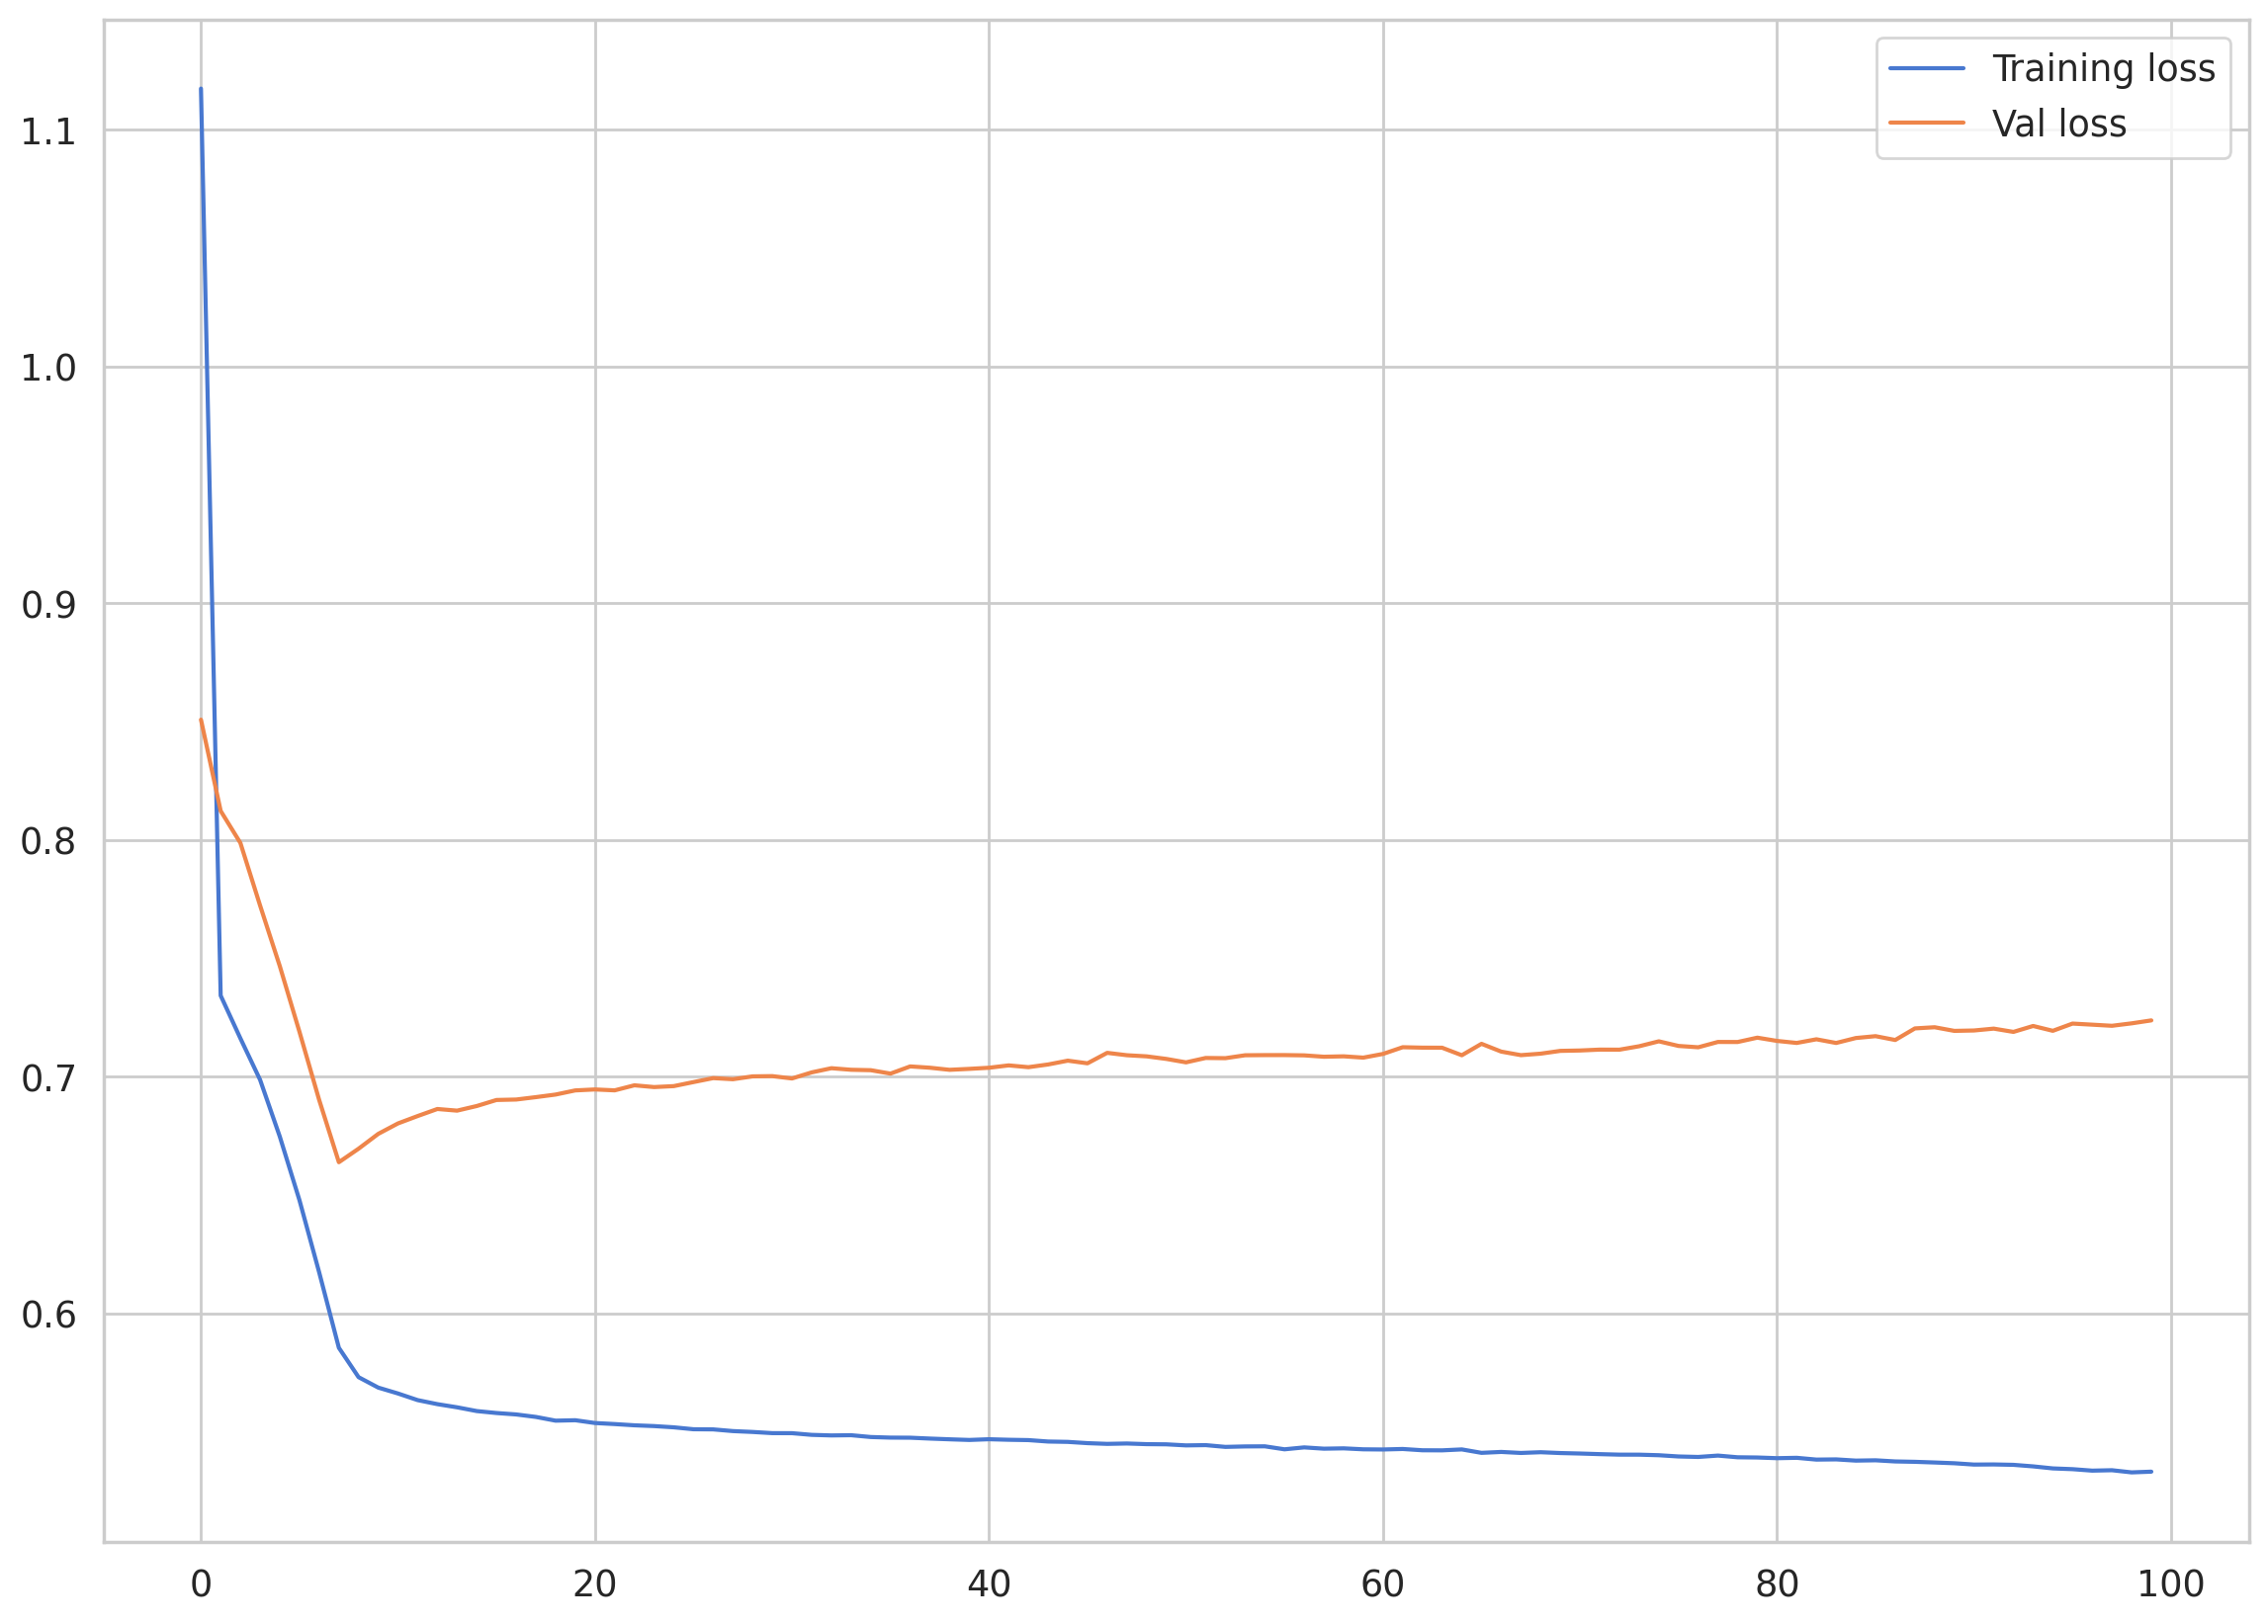

In [ ]:
# float
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

# 예측

## float()

In [ ]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

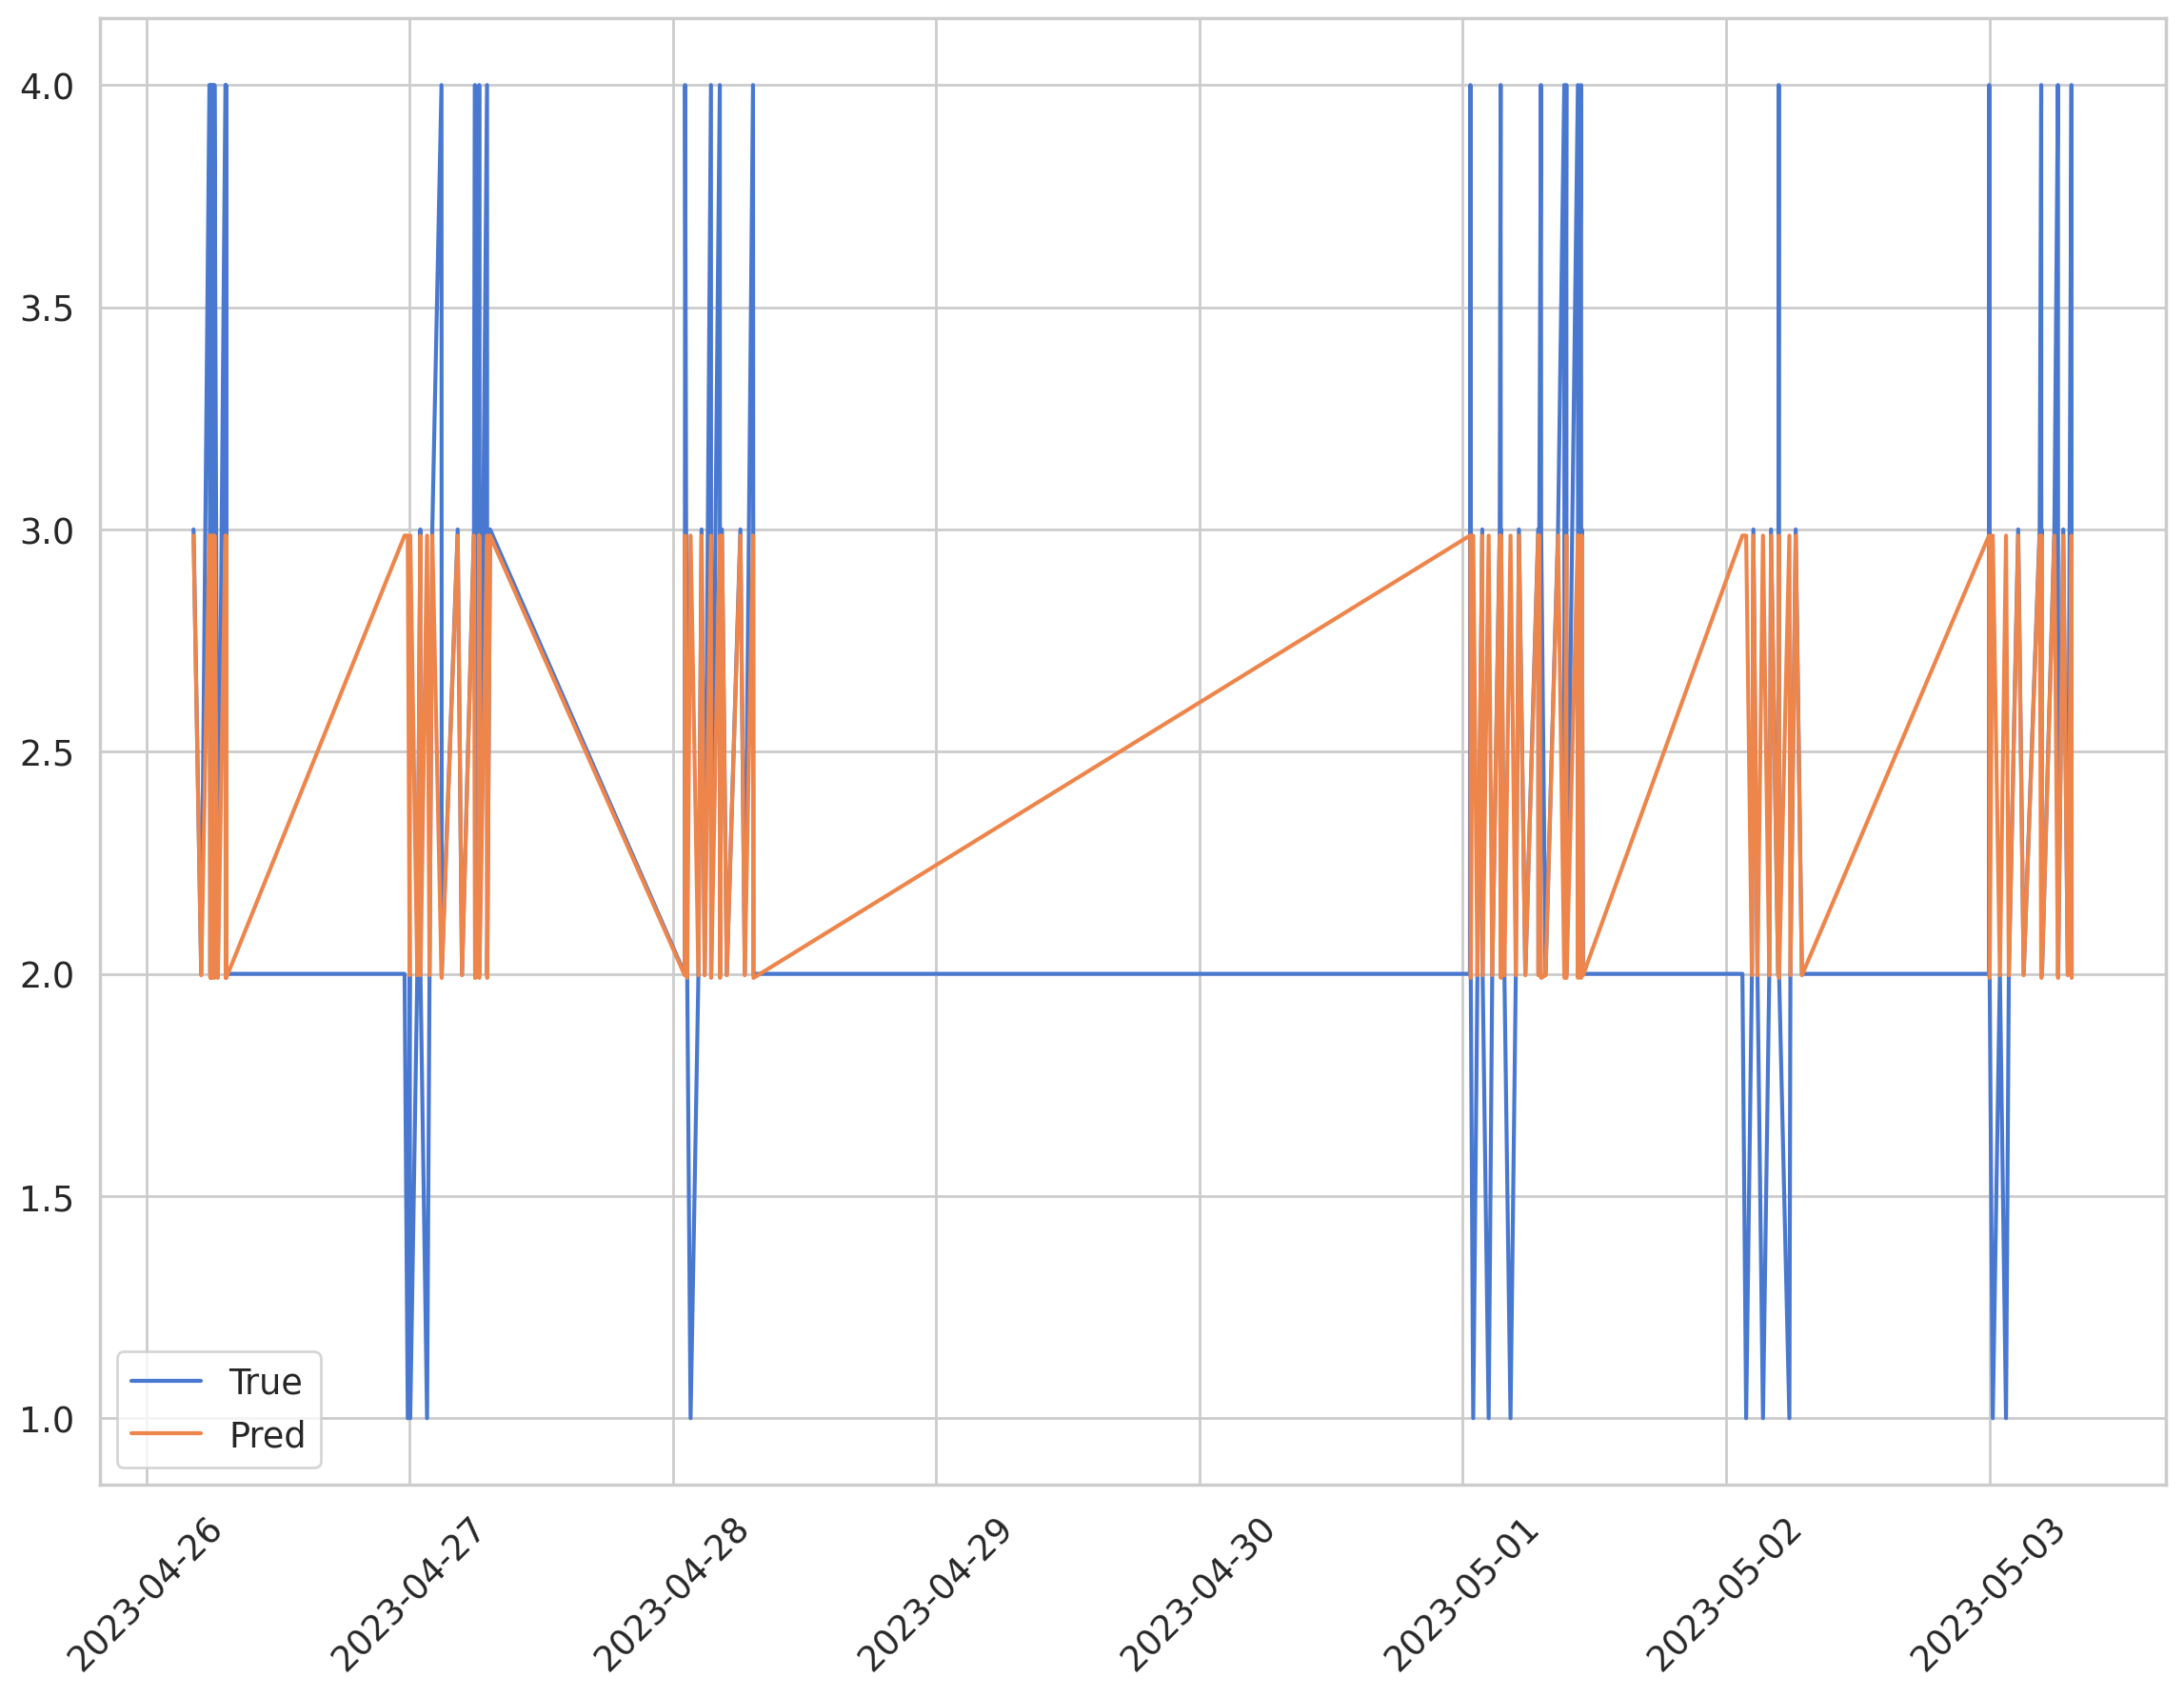

In [ ]:
plt.plot(weekday.index[-len(y_test):], np.array(y_test), label='True')
plt.plot(weekday.index[-len(preds):], np.array(preds), label='Pred')
plt.xticks(rotation=45)
plt.legend()

## int()

In [ ]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

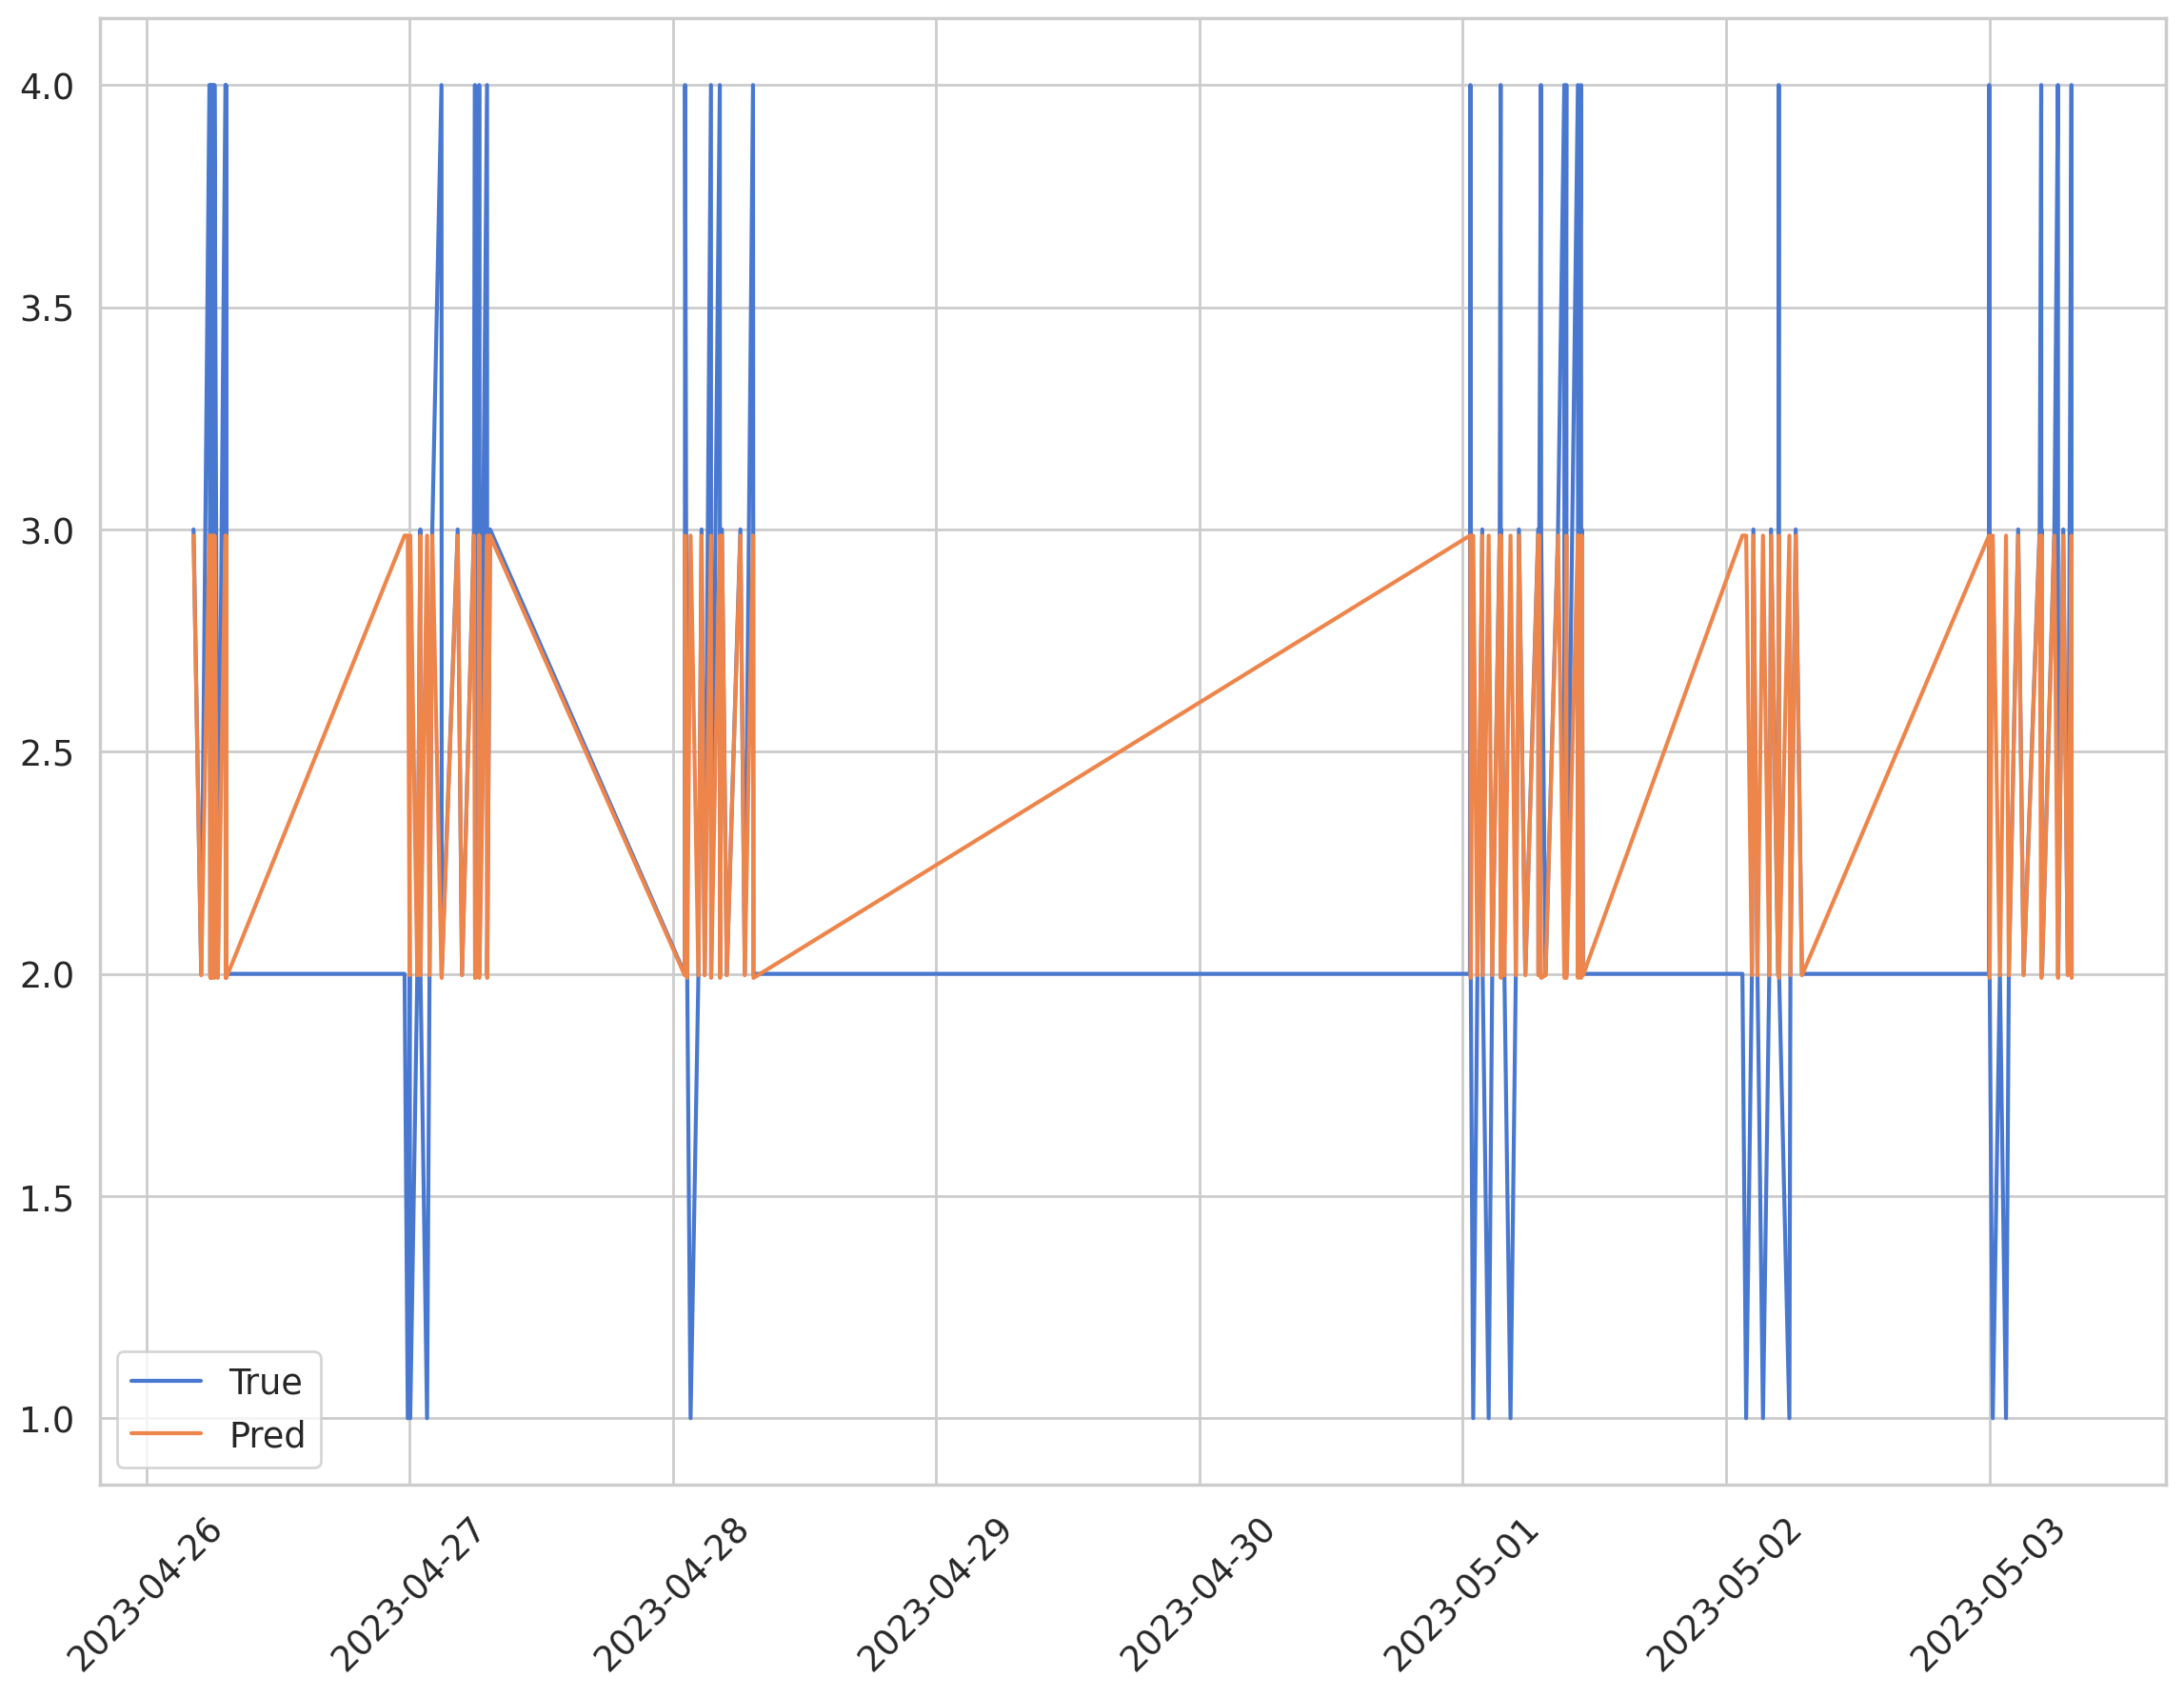

In [ ]:
plt.plot(weekday.index[-len(y_test):], np.array(y_test), label='True')
plt.plot(weekday.index[-len(preds):], np.array(preds), label='Pred')
plt.xticks(rotation=45)
plt.legend()